<h1><center>OMSF 2024: OpenFE Demo</center></h1>

<center><i><b>Exploring MCL-1 fragment RBFEs using OpenFE</b></i></center>
<br/><br/>

<h2><center>Tutorial Overview</center></h2>

This tutorial demonstrates how to set up and run a network of **Relative Binding Free Energy (RBFE)** calculations using the OpenFE toolkit.

Specifically we cover:
* Loading and defining systems
* Atom mapping and network creation
* Creating & running RBFE simulations
* Analyzing free energy results
* Using the Python & CLI interfaces

![rbfe_cycle](images/rbfe_thermocycle.png)

<h2><center>Test case: MCL-1 Fragments</center></h2>

* A set of **14 fragment** elaborations from a screen by *Friberg et al., J. Med Chem. 2013*.

* Part of the FEP+ fragment study by *Steinbrecher et al. J. Chem. Inf. Model 2015*

<center><img src="images/mcl1_frag_elaboration.png"/></center>

<center><img src="images/mcl1_site_crop.png"/></center>

<h2><center>Inspecting the Ligands</center></h2>

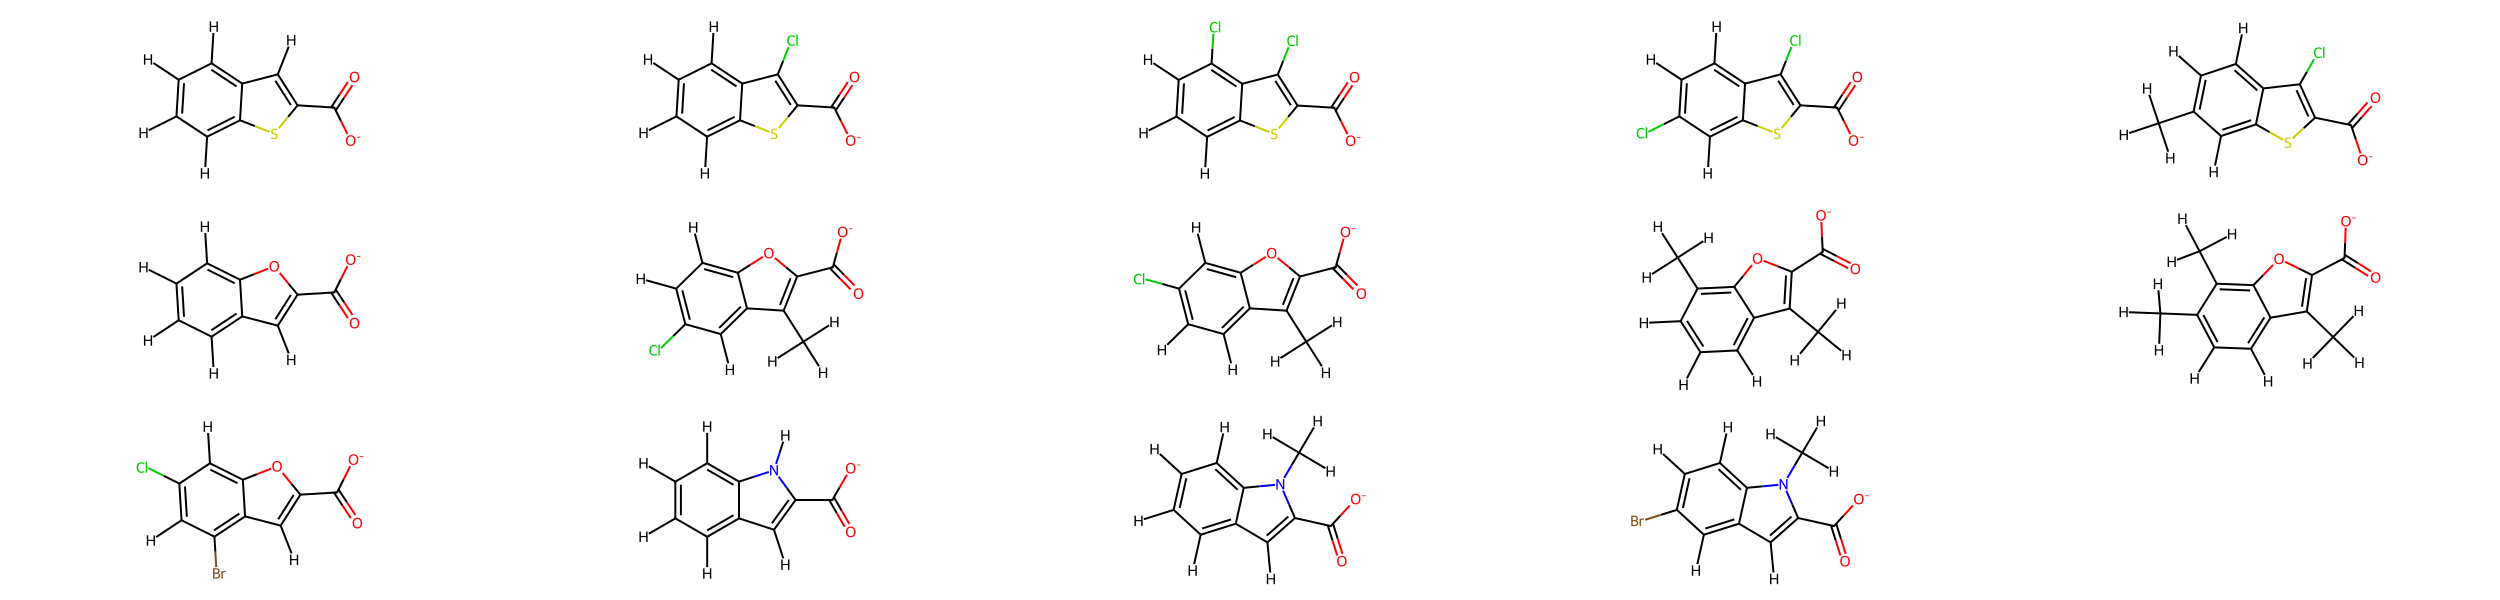

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

# Extract SDF contents, generate 2D coords (note: non-aligned scaffold!)
ligand_rdmols = [m for m in Chem.SDMolSupplier('ligands.sdf', removeHs=False)]
[AllChem.Compute2DCoords(ligand) for ligand in ligand_rdmols]

Chem.Draw.MolsToGridImage(ligand_rdmols, molsPerRow=5, subImgSize=(500,200))

<h2><center>The RBFE workflow</center></h2>

| **Step** | **External Tooling Used** |
|:---------|:----------------|
| 1. Creating OpenFE Components | RDKit, OpenMM, OpenFF |
| 2. Generating Atom Mappings | Kartograf, RDKit |
| 3. Creating a Ligand Network | Lomap, Networkx |
| 4. Defining a network of RBFE Alchemical Transformations | |
| 5. Running the simulations | OpenMM, OpenMMTools, Perses, OpenFF |
| 6. Gathering results | OpenMMTools, PyMBAR |
| 7. Analysis | Cinnabar, Matplotlib |

<center><img src="images/RBFE_overview.png"/></center>

<h2><center>OpenFE Components</center></h2>

In [2]:
import openfe
from openff.units import unit

# ProteinComponent
protein = openfe.ProteinComponent.from_pdb_file(
    'protein.pdb'
)

# SolventComponent
solvent = openfe.SolventComponent(
    positive_ion='Na', negative_ion='Cl',
    neutralize=True,
    ion_concentration=0.15*unit.nanomolar
)

# Ligands
ligand_mols = [
    openfe.SmallMoleculeComponent(sdf)
    for sdf in Chem.SDMolSupplier(
        'ligands.sdf', removeHs=False
    )
]

<center><img src="images/OpenFEComponents.png"/></center>

<h2><center>Mapping Ligands</center></h2>

An atom mapping defines the atoms being mutated (and how) during the alchemical transformation.

* Uncoloured atoms: "mapped same elements"
* Blue atoms: "mapped different elements"
* Red atoms: "endstate dummy atoms"

In OpenFE we currently have two atom mappers:
1. `LomapAtomMapper` (MCS-based)

2. `KartografAtomMapper` (Geometry-based)

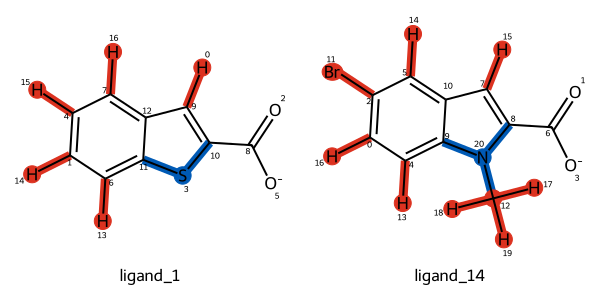

In [3]:
from kartograf import KartografAtomMapper

mapper = KartografAtomMapper(atom_map_hydrogens=False)

atom_mapping = next(
    mapper.suggest_mappings(
        ligand_mols[0], ligand_mols[-1]
    )
)

atom_mapping

<h2><center>Mapping Ligands</center></h2>

We can also visualize the mappings in 3D!

*Note: atoms that have the same sphere color in both end states are mapped (i.e. will be transformed into dummy atoms in the opposite end state), whilst those without spheres are unmaped!*

In [4]:
from openfe.utils import visualization_3D

visualization_3D.view_mapping_3d(atom_mapping)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

<h2><center>Ligand Transformation Networks</center></h2>

We can use a mapper and a mapping scorer (e.g. `default_lomap_score`) to plan transformation networks between ligands of interest.

OpenFE can create various networks, including:
* Minimum Spanning Tree networks (MST)
* LOMAP networks
* Radial networks
* Loading external networks (e.g. FEP+)
* And many more using Konnektor!

In [5]:
from openfe.setup.ligand_network_planning import (
    generate_lomap_network,
    generate_minimal_spanning_network,
    generate_radial_network,
)
from openfe import lomap_scorers

# Creating a Lomap network
lomap_network = generate_lomap_network(
    molecules=ligand_mols,
    scorer=lomap_scorers.default_lomap_score,
    mappers=[KartografAtomMapper()]
)

# Creating an MST network
mst_network = generate_minimal_spanning_network(
    ligands=ligand_mols,
    scorer=lomap_scorers.default_lomap_score,
    mappers=[KartografAtomMapper()]
)

atom mapping:  {12: 13, 13: 14, 14: 11, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 12, 20: 20}


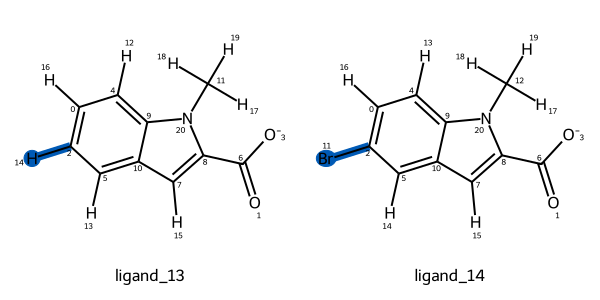

In [6]:
# A network is a collecting of mappings

mst_edges = [edge for edge in mst_network.edges]

print("atom mapping: ", mst_edges[0].componentA_to_componentB)

mst_edges[0]

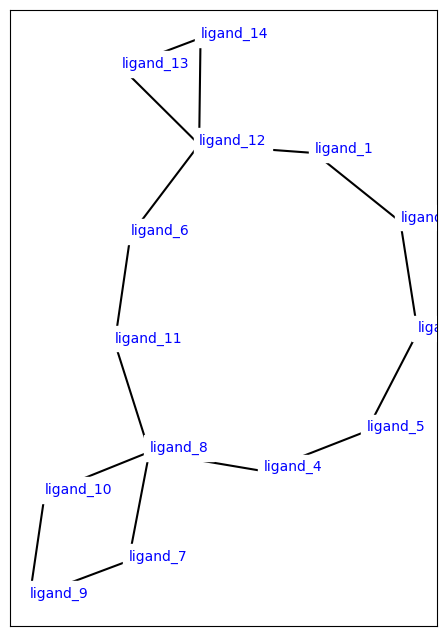

In [8]:
# We can visualize the networks too!
# Note: small visual artifact bug to be fixed ;)

from openfe.utils.atommapping_network_plotting import plot_atommapping_network

plot_atommapping_network(lomap_network)

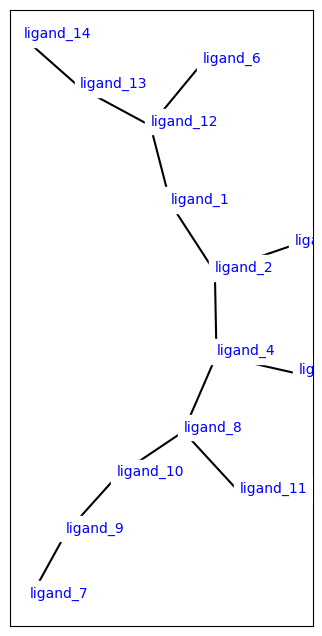

In [9]:
plot_atommapping_network(mst_network)

<h2><center>Creating an RBFE cycle</center></h2>

For each edge in our ligand network we can define a set of simulations to allow us to recover the **binding free energy**.

To do this we need to define:
  - 2 solvent states
  - 2 complex states
  - A state transformation simulation protocol

![rbfe_cycle](images/rbfe_thermocycle.png)

<h2><center>Defining end states</center></h2>

* `ChemicalSystems` can be defined for each end state of the cycle.

* These define the `Components` making up each state.

* Free energy Protocols take multiple ChemicalSystems to define the transformation being simulated.

![rbfe_cycle](images/rbfe_thermocycle.png)

<h2><center>Defining end states</center></h2>

In [10]:
# Selecting a specific edge
edge = mst_edges[0]

# Components are collated into ChemicalSystems
ligand_A_complex = openfe.ChemicalSystem(
    {'ligand': edge.componentA,
     'protein': protein,
     'solvent': solvent}
)

ligand_A_solvent = openfe.ChemicalSystem(
    {'ligand': edge.componentA,
     'solvent': solvent}
)

ligand_B_complex = openfe.ChemicalSystem(
    {'ligand': edge.componentB,
     'protein': protein,
     'solvent': solvent}
)

ligand_B_solvent = openfe.ChemicalSystem(
    {'ligand': edge.componentB,
     'solvent': solvent}
)

In [11]:
# We can inspect the equality of these
# ChemicalSystems to identify differences

another_complex = openfe.ChemicalSystem(
    {'ligand': edge.componentA,
     'protein': protein,
     'solvent': solvent}
)

print(ligand_A_complex == another_complex)

print(ligand_A_complex == ligand_B_complex)


True
False


<h2><center>Creating a simulation Protocol</center></h2>

An OpenFE **Protocol** defines how a simulation will take place.

Here we use the `RelativeHybridTopologyProtocol`, based on Perses, which:
  * Uses a hybrid topology approach
  * Allows for equilibrium samplers; HREX, SAMS, and independent windows
  * Uses OpenMM as a simulation engine

In [12]:
from openfe.protocols.openmm_rfe import (
    RelativeHybridTopologyProtocol
)

# Protocols require settings, each has a default set
settings = RelativeHybridTopologyProtocol.default_settings()

# We can get the FF version
print(settings.forcefield_settings.small_molecule_forcefield)

# We can set the FF version
settings.forcefield_settings.small_molecule_forcefield = 'openff-2.2'

openff-2.1.1


<h2><center>Creating a simulation Protocol</center></h2>

* **Protocol** objects are created from their settings and are immutable.

* **Protocol** objects define how to apply a Transformation to a set of input ChemicalSystems & atom mappings.

* **Protocol** objects can be re-used to define multiple simulations.

In [13]:
# Creating a Protocol for our RBFE simulations

rbfe_protocol = RelativeHybridTopologyProtocol(
    settings=settings
)

<h2><center>Creating Transformations</center></h2>

With `ChemicalSystem`s and a `Protocol` defined, we can create a set of `Transformation`s for our RBFE cycle.

A `Transformation` contains everything necessary to run a single simulation. For our chosen RFE Protocol this requires:
  * Two `ChemicalSystem` defining the end states
  * An atom mapping between the transforming ligands
  * A `Protocol` object
  * A name (optional)

In [14]:
transformation_complex = openfe.Transformation(
    stateA=ligand_A_complex,
    stateB=ligand_B_complex,
    mapping=edge,
    protocol=rbfe_protocol,
    name="A_to_B_transformation_complex"
)

transformation_solvent = openfe.Transformation(
    stateA=ligand_A_solvent,
    stateB=ligand_B_solvent,
    mapping=edge,
    protocol=rbfe_protocol,
    name="A_to_B_transformation_solvent"
)

<h2><center>Saving Transformations</center></h2>

`Transformation`s can then be saved to file (JSON) for execution at a later date.

Executing a `Transformation` (see later) will yield a free energy estimate for that leg of the thermodynamic cycle.

In [15]:
import pathlib

out_dir = pathlib.Path("single_transform")
out_dir.mkdir(exist_ok=True)

transformation_complex.dump(
    out_dir / f"{transformation_complex.name}.json"
)

transformation_solvent.dump(
    out_dir / f"{transformation_solvent.name}.json"
)

<h2><center>Networks of Transformations (AlchemicalNetworks)</center></h2>

We can create `AlchemicalNetwork`s which contain all the `Transformation` for all the simulations necessary for a network of RBFE calculations.

In [16]:
transformations = []
for mapping in mst_network.edges:
    for leg in ['solvent', 'complex']:
        # use the solvent and protein created above
        sysA_dict = {'ligand': mapping.componentA,
                     'solvent': solvent}
        sysB_dict = {'ligand': mapping.componentB,
                     'solvent': solvent}
        
        if leg == 'complex':
            sysA_dict['protein'] = protein
            sysB_dict['protein'] = protein
        
        sysA = openfe.ChemicalSystem(sysA_dict)
        sysB = openfe.ChemicalSystem(sysB_dict)
        
        name = (f"{leg}_{mapping.componentA.name}_"
                f"{mapping.componentA.name}")
        
        transformation = openfe.Transformation(
            stateA=sysA,
            stateB=sysB,
            mapping={'ligand': mapping},
            protocol=rbfe_protocol,
            name=name
        )
        transformations.append(transformation)

network = openfe.AlchemicalNetwork(transformations)

In [17]:
# Similarly we can write out all the AlchemicalNetwork
# Transformations to disk

# first we create the directory
transformation_dir = pathlib.Path("networktransforms")
transformation_dir.mkdir(exist_ok=True)

# then we write out each transformation
for transformation in network.edges:
    transformation.dump(transformation_dir / f"{transformation.name}.json")

In [18]:
!ls networktransforms

complex_ligand_12_ligand_12.json  solvent_ligand_12_ligand_12.json
complex_ligand_13_ligand_13.json  solvent_ligand_13_ligand_13.json
complex_ligand_1_ligand_1.json	  solvent_ligand_1_ligand_1.json
complex_ligand_2_ligand_2.json	  solvent_ligand_2_ligand_2.json
complex_ligand_4_ligand_4.json	  solvent_ligand_4_ligand_4.json
complex_ligand_6_ligand_6.json	  solvent_ligand_6_ligand_6.json
complex_ligand_7_ligand_7.json	  solvent_ligand_7_ligand_7.json
complex_ligand_8_ligand_8.json	  solvent_ligand_8_ligand_8.json
complex_ligand_9_ligand_9.json	  solvent_ligand_9_ligand_9.json


<h2><center>Using the CLI instead</center></h2>

You can instead do all of this using a single line of the CLI!

The CLI can be quite convenient when you want to use default options. We are adding the ability to customize things using an optionall YAML file. For now this is limited to selecting atom mapper and network options.

*Example YAML settings*:
```yaml
mapper:
  method: kartograf
  
network:
  method: generate_minimal_spanning_network
```

In [19]:
!openfe plan-rbfe-network -M ligands.sdf -p protein.pdb -o cli_setup -s settings.yaml

RBFE-NETWORK PLANNER
______________________

Parsing in Files: 
	Got input: 
		Small Molecules: SmallMoleculeComponent(name=ligand_1) SmallMoleculeComponent(name=ligand_2) SmallMoleculeComponent(name=ligand_3) SmallMoleculeComponent(name=ligand_4) SmallMoleculeComponent(name=ligand_5) SmallMoleculeComponent(name=ligand_6) SmallMoleculeComponent(name=ligand_7) SmallMoleculeComponent(name=ligand_8) SmallMoleculeComponent(name=ligand_9) SmallMoleculeComponent(name=ligand_10) SmallMoleculeComponent(name=ligand_11) SmallMoleculeComponent(name=ligand_12) SmallMoleculeComponent(name=ligand_13) SmallMoleculeComponent(name=ligand_14)
		Protein: ProteinComponent(name=)
		Cofactors: []
		Solvent: SolventComponent(name=O, Na+, Cl-)

Using Options:
	Mapper: <KartografAtomMapper-acc5b4e191cf1b31bc4b19392d44263b>
	Mapping Scorer: <function default_lomap_score at 0x7959e9ba8040>
	Networker: functools.partial(<function generate_minimal_spanning_network at 0x7959e6b13740>)

Planning RBFE-Campaign:
	Done

<h2><center>Running simulations</center></h2>

We can run each leg of our simulation using the `quickrun` command.

This takes one of the JSON files we wrote, runs the simulation, and writes an output JSON file with the simulation results.

```
openfe quickrun path/to/transformation.json -o results.json -d working-directory
```

You can loop over a list of JSON files to run through a network, or distribute your `quickrun` commands over a HPC cluster.

**Note:** alternative execution engines can also be used, such as [Alchemiscale](https://github.com/openforcefield/alchemiscale).

<h2><center>Gathering results</center></h2>

Once complete, the `quickrun` command will create a results JSON file and an accompanying directory with relevant simulation files.

In [21]:
!ls results_jsons/easy_rbfe_ligand_12_solvent_ligand_13_solvent/shared*

results_jsons/easy_rbfe_ligand_12_solvent_ligand_13_solvent/shared_RelativeHybridTopologyProtocolUnit-14e3a226636e44d08136645070e863dd_attempt_0:
db.json				 replica_exchange_matrix.png
forward_reverse_convergence.png  replica_state_timeseries.png
hybrid_system.pdb		 simulation_real_time_analysis.yaml
ligand_RMSD.png			 structural_analysis.json
mbar_overlap_matrix.png

results_jsons/easy_rbfe_ligand_12_solvent_ligand_13_solvent/shared_RelativeHybridTopologyProtocolUnit-a04a2745b0fc4fa79a4f087dfb0e78c7_attempt_0:
db.json				 replica_exchange_matrix.png
forward_reverse_convergence.png  replica_state_timeseries.png
hybrid_system.pdb		 simulation_real_time_analysis.yaml
ligand_RMSD.png			 structural_analysis.json
mbar_overlap_matrix.png

results_jsons/easy_rbfe_ligand_12_solvent_ligand_13_solvent/shared_RelativeHybridTopologyProtocolUnit-be5ac08159a948f58c5b40195b7c777c_attempt_0:
db.json				 replica_exchange_matrix.png
forward_reverse_convergence.png  replica_state_timeseries.png
hybrid_s

<h2><center>Gathering results</center></h2>

These files include various structure (`.pdb`) and trajectory (`.nc`) files, and outputs from automated analyses.

For example we can find a PNG of the MBAR overlap matrix:

<center><img src="results_jsons/easy_rbfe_ligand_12_solvent_ligand_13_solvent/shared_RelativeHybridTopologyProtocolUnit-be5ac08159a948f58c5b40195b7c777c_attempt_0/mbar_overlap_matrix.png"/></center>

<h2><center>Gathering results</center></h2>

We can use the `gather` method to extract results directly from our simulations.

Here we report the relative binding free energies for each ligand pair, where the estimates and uncertainty are the average and standard deviation of three independent repeat.

In [23]:
!openfe gather results_jsons/ --report ddg

ligand_i	ligand_j	DDG(i->j) (kcal/mol)	uncertainty (kcal/mol)
ligand_1	ligand_2	-2.9	0.2
ligand_1	ligand_6	0.5	0.3
ligand_12	ligand_13	-1.4	0.1
ligand_13	ligand_14	-0.2	0.2
ligand_2	ligand_3	-1.42	0.06
ligand_2	ligand_4	-0.43	0.08
ligand_4	ligand_5	0.7	0.1
ligand_4	ligand_8	0.4	0.2
ligand_6	ligand_11	-2.27	0.10
ligand_6	ligand_12	0.65	0.07
ligand_6	ligand_7	-1.9	0.1
ligand_8	ligand_10	-0.0	0.1
ligand_9	ligand_10	0.42	0.09


<h2><center>Gathering results</center></h2>

There is also an option to get the absolute free energies using Maximum Likelihood Estimation with the [cinnabar](https://github.com/OpenFreeEnergy/cinnabar) toolkit.

In [24]:
!openfe gather results_jsons/ --report dg

ligand	DG(MLE) (kcal/mol)	uncertainty (kcal/mol)
ligand_1	1.7	0.2
ligand_2	-1.2	0.2
ligand_6	2.3	0.2
ligand_12	2.9	0.2
ligand_13	1.5	0.2
ligand_14	1.3	0.3
ligand_3	-2.6	0.2
ligand_4	-1.6	0.2
ligand_5	-0.8	0.2
ligand_8	-1.1	0.3
ligand_11	-0.0	0.2
ligand_7	0.4	0.2
ligand_10	-1.2	0.3
ligand_9	-1.6	0.3


<h2><center>Gathering results</center></h2>

With a little bit of data wrangling with experimental results, and the use of the [cinnabar](https://github.com/OpenFreeEnergy/cinnabar) toolkit, we can plot these results out.

By comparison, the 2015 Steinbrecher et al. study yielded very similar results with within error RMSE and R2 values.

<center><img src="mcl1_exp_DDG.png"/></center>

<center><img src="mcl1_exp_DG.png"/></center>